# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [71]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
CONFIDENCE = 0.4
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint", filter_threshold=CONFIDENCE).eval().to(device)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Load

In [6]:
! pip install geopandas pandas shapely fiona rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 96.8 MB/s eta 0:00:00


In [7]:
import geopandas as gpd
import pandas as pd
from shapely import box
import fiona
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import rasterio
import matplotlib.pyplot as plt

In [8]:
def read_gpkg_layers_combined(gpkg_path, layer_names):
    """
    Read multiple layers and combine them into a single GeoDataFrame with a 'layer' column

    Args:
        gpkg_path (str): Path to the GeoPackage file
        layer_names (list): List of layer names to read

    Returns:
        GeoDataFrame: Combined GeoDataFrame with all layers
    """
    # Read each layer and add layer name as a column
    gdfs = []
    for layer in layer_names:
        try:
            gdf = gpd.read_file(gpkg_path, layer=layer)
            gdf['layer'] = layer  # Add layer name as a column
            gdfs.append(gdf)
            print(f"Successfully loaded layer: {layer}")
        except Exception as e:
            print(f"Error loading layer {layer}: {str(e)}")

    # Combine all layers into one GeoDataFrame
    combined_gdf = pd.concat(gdfs, ignore_index=True)
    return combined_gdf

In [26]:
from pathlib import Path
STADT = "Stendal"
prefix = "mgb1/"
BASE_PATH = Path(f"/content/drive/MyDrive/data/{STADT}")
gpkg_path = BASE_PATH / "Raw_Data.gpkg"
layers = fiona.listlayers(gpkg_path)
print("Available layers:")
for layer in layers:
    print(f"- {layer}")

Available layers:
- PLANGEBIET
- LAGEPLAENE
- MP_HU
- MP_FG
- ALKIS_HU
- ALKIS_ADRESSE
- ALKIS_FLUR
- MP_TRASSEN
- MP_APL


In [15]:
layers = ["LAGEPLAENE", "ALKIS_HU", "ALKIS_FLUR"]
# Read all layers into a single GeoDataFrame
stadt_df = read_gpkg_layers_combined(gpkg_path, layers)
lp = stadt_df[stadt_df['layer'] == 'LAGEPLAENE']
flur = stadt_df[stadt_df['layer'] == 'ALKIS_FLUR']
haus = stadt_df[stadt_df['layer'] == 'ALKIS_HU']

Successfully loaded layer: LAGEPLAENE
Successfully loaded layer: ALKIS_HU
Successfully loaded layer: ALKIS_FLUR


<Axes: >

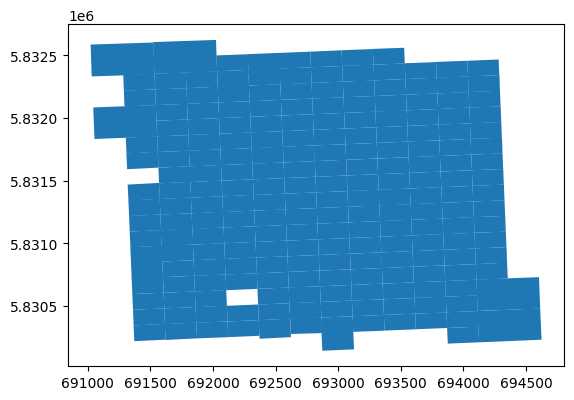

In [16]:
lp.plot()

<Axes: >

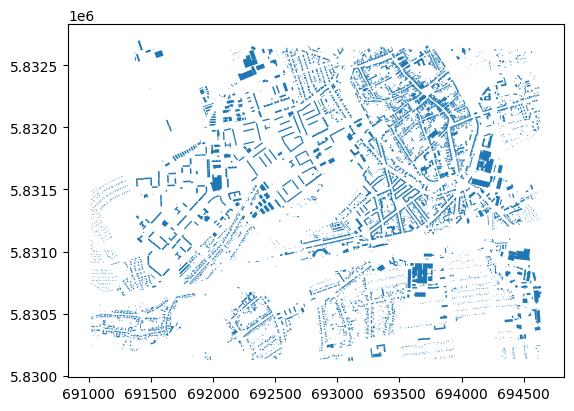

In [17]:
haus.plot()

<Axes: >

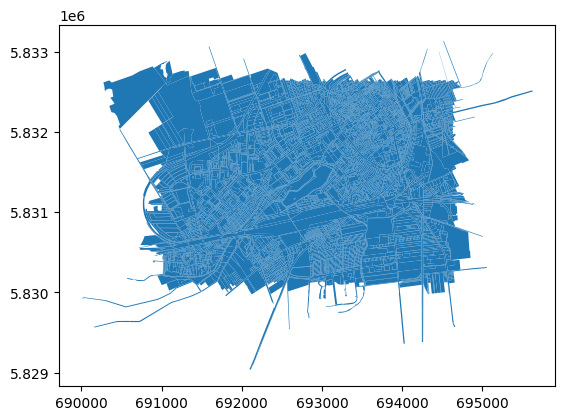

In [18]:
flur.plot()

In [19]:
def get_affine_transformation(tfw_string):
    """Create affine transformation from TFW parameters in pipe-separated string format."""
    tfw_params = [float(x) for x in tfw_string.split('|')]
    xoffset, px_w, rot1, yoffset, rot2, px_h = tfw_params
    geotransform = (xoffset, px_w, rot1, yoffset, rot2, px_h)
    return Affine.from_gdal(*geotransform)

# Create a new column for affine transformation
stadt_df['affine_transform'] = None

# Apply transformation only to LAGEPLAENE rows
mask = stadt_df['layer'] == 'LAGEPLAENE'
stadt_df.loc[mask, 'affine_transform'] = stadt_df.loc[mask, 'TFW'].apply(get_affine_transformation)

# Verify
print("Number of affine transforms created:", stadt_df['affine_transform'].notna().sum())
print("\nExample of first LAGEPLAENE transform:")
print(stadt_df[stadt_df['layer'] == 'LAGEPLAENE']['affine_transform'].iloc[0])

Number of affine transforms created: 211

Example of first LAGEPLAENE transform:
| 0.03, 0.00, 691345.47|
| 0.00,-0.03, 5830844.14|
| 0.00, 0.00, 1.00|


In [30]:
stadt_df

,NAME,TFW,WIDTH,HEIGHT,DATABASE_ID,geometry,layer,FUNKTION,HU_ID,Nutzung,Objektart,affine_transform
0,mgb1/8828ab,691345.4732|0.0317943251|0.001451167847|583084...,7871.0,4295.0,60.0,"POLYGON ((691345.473 5830844.137, 691595.726 5...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.0317943251, 0.001451167847, 691345.4732, 0...."
1,mgb1/8828ad,691351.1187|0.03179182459|0.001271360732|58307...,7865.0,3970.0,60.0,"POLYGON ((691351.119 5830719.339, 691601.161 5...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03179182459, 0.001271360732, 691351.1187, 0..."
2,mgb1/8828ba,691595.848|0.03177956616|0.001306713676|583085...,7859.0,3965.0,60.0,"POLYGON ((691595.848 5830854.41, 691845.604 58...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03177956616, 0.001306713676, 691595.848, 0...."
3,mgb1/8828bb,691845.0007|0.03177973516|0.001466964258|58308...,7877.0,4008.0,60.0,"POLYGON ((691845.001 5830864.799, 692095.33 58...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03177973516, 0.001466964258, 691845.0007, 0..."
4,mgb1/8828bc,691600.9705|0.03178174873|0.001322649449|58307...,7860.0,3975.0,60.0,"POLYGON ((691600.971 5830729.514, 691850.775 5...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03178174873, 0.001322649449, 691600.9705, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
18379,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((694285.227 5832413.659, 694282...",ALKIS_FLUR,NaN,NaN,,Fliessgewaesser,None
18380,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((692851.063 5831839.722, 692831...",ALKIS_FLUR,NaN,NaN,Handel und Dienstleistung,Industrie Und Gewerbeflaeche,None
18381,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((691988.866 5830816.087, 691995...",ALKIS_FLUR,NaN,NaN,,Wohnbauflaeche,None
18382,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((693000.708 5832463.496, 692991...",ALKIS_FLUR,NaN,NaN,,Wohnbauflaeche,None


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


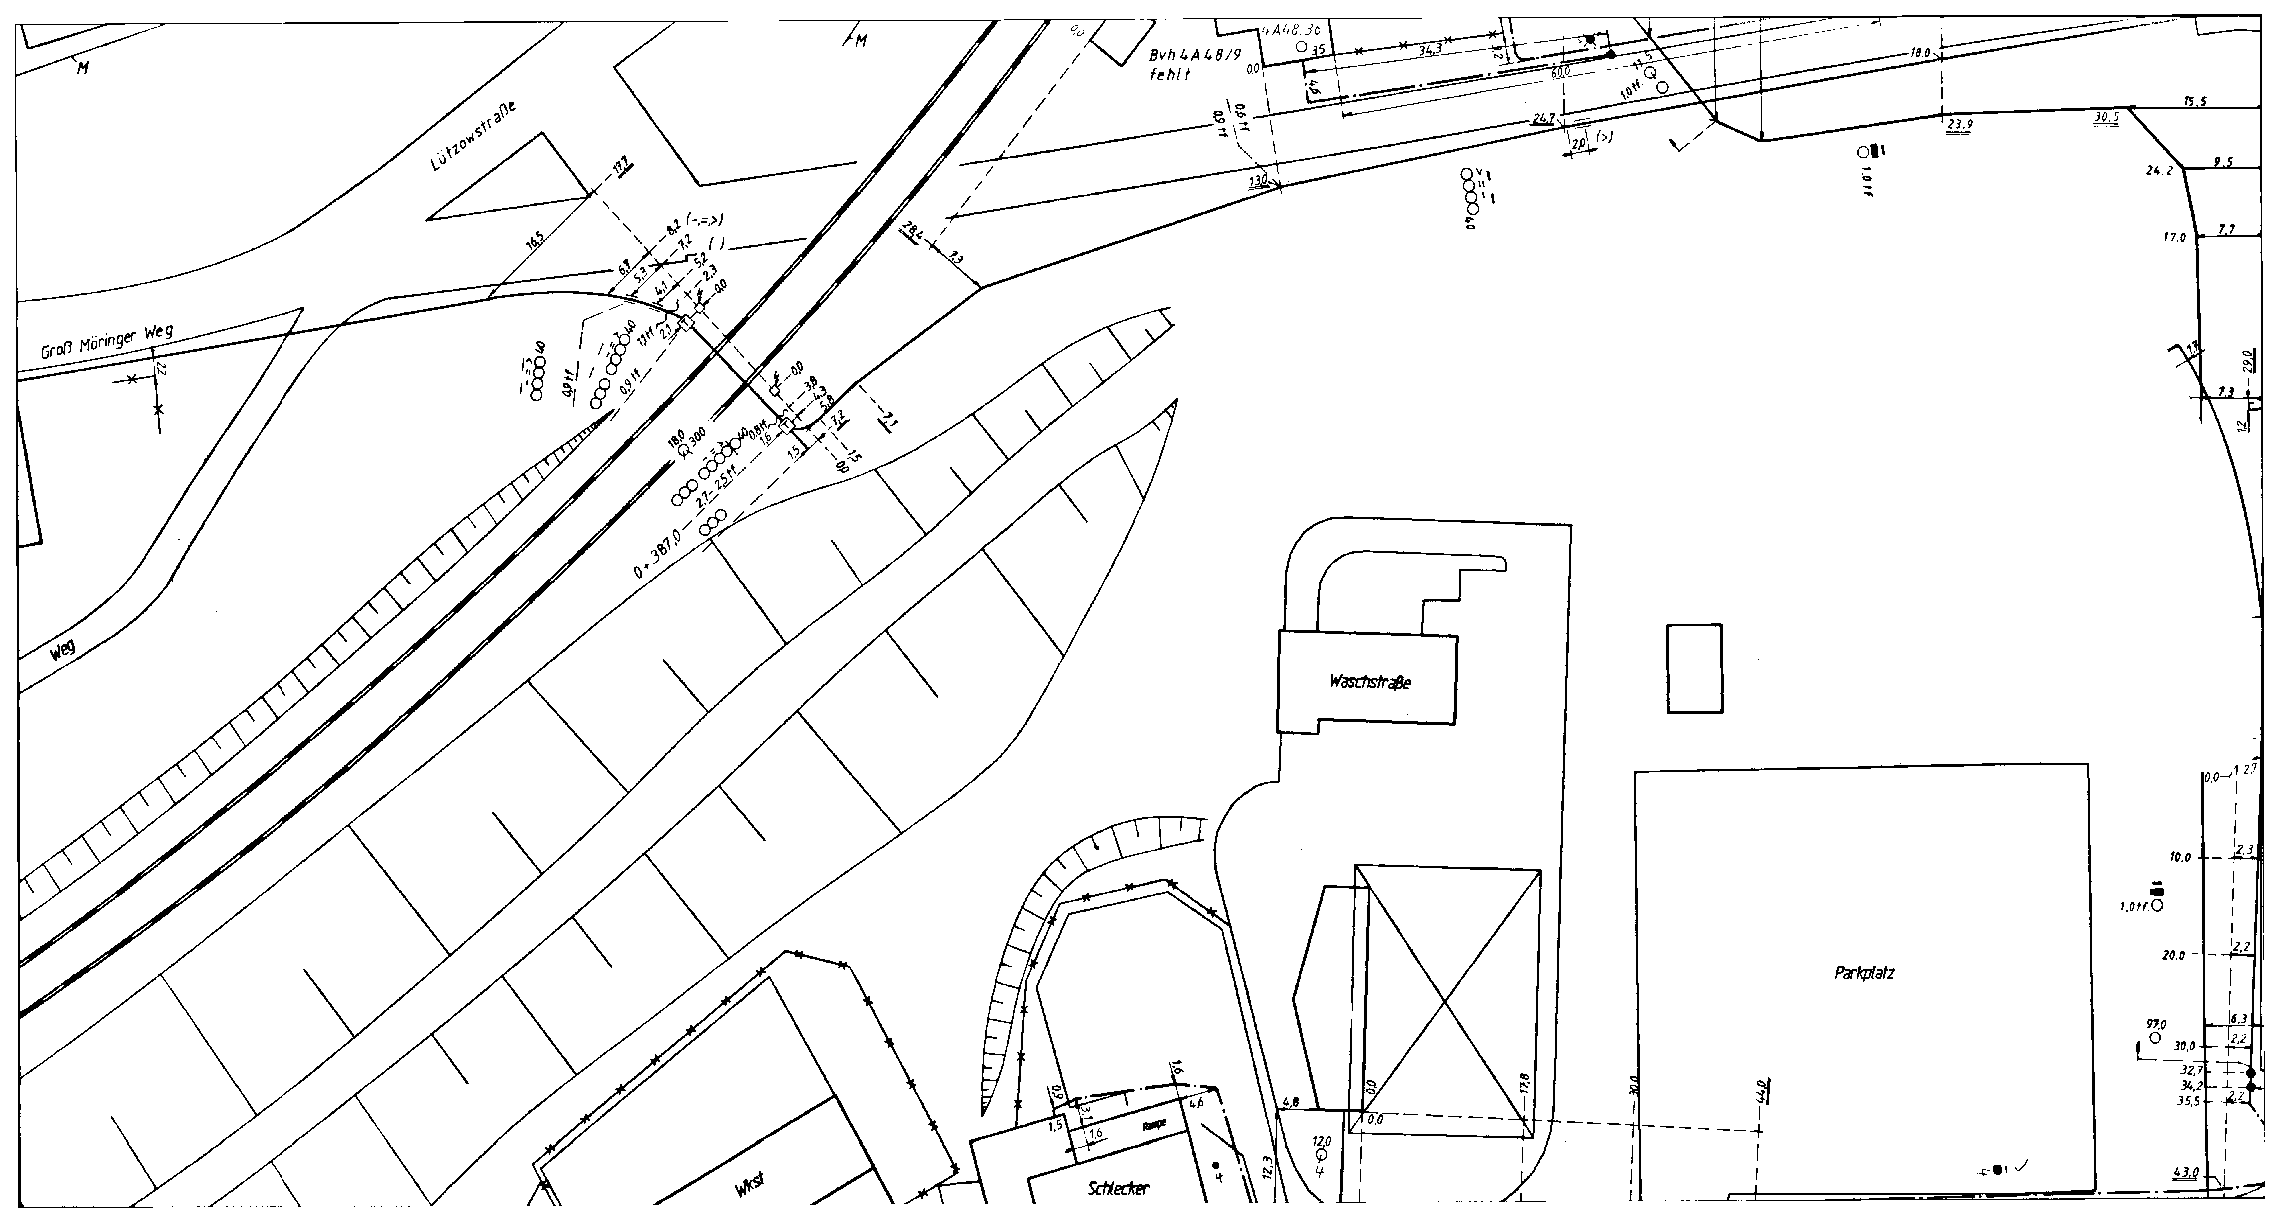

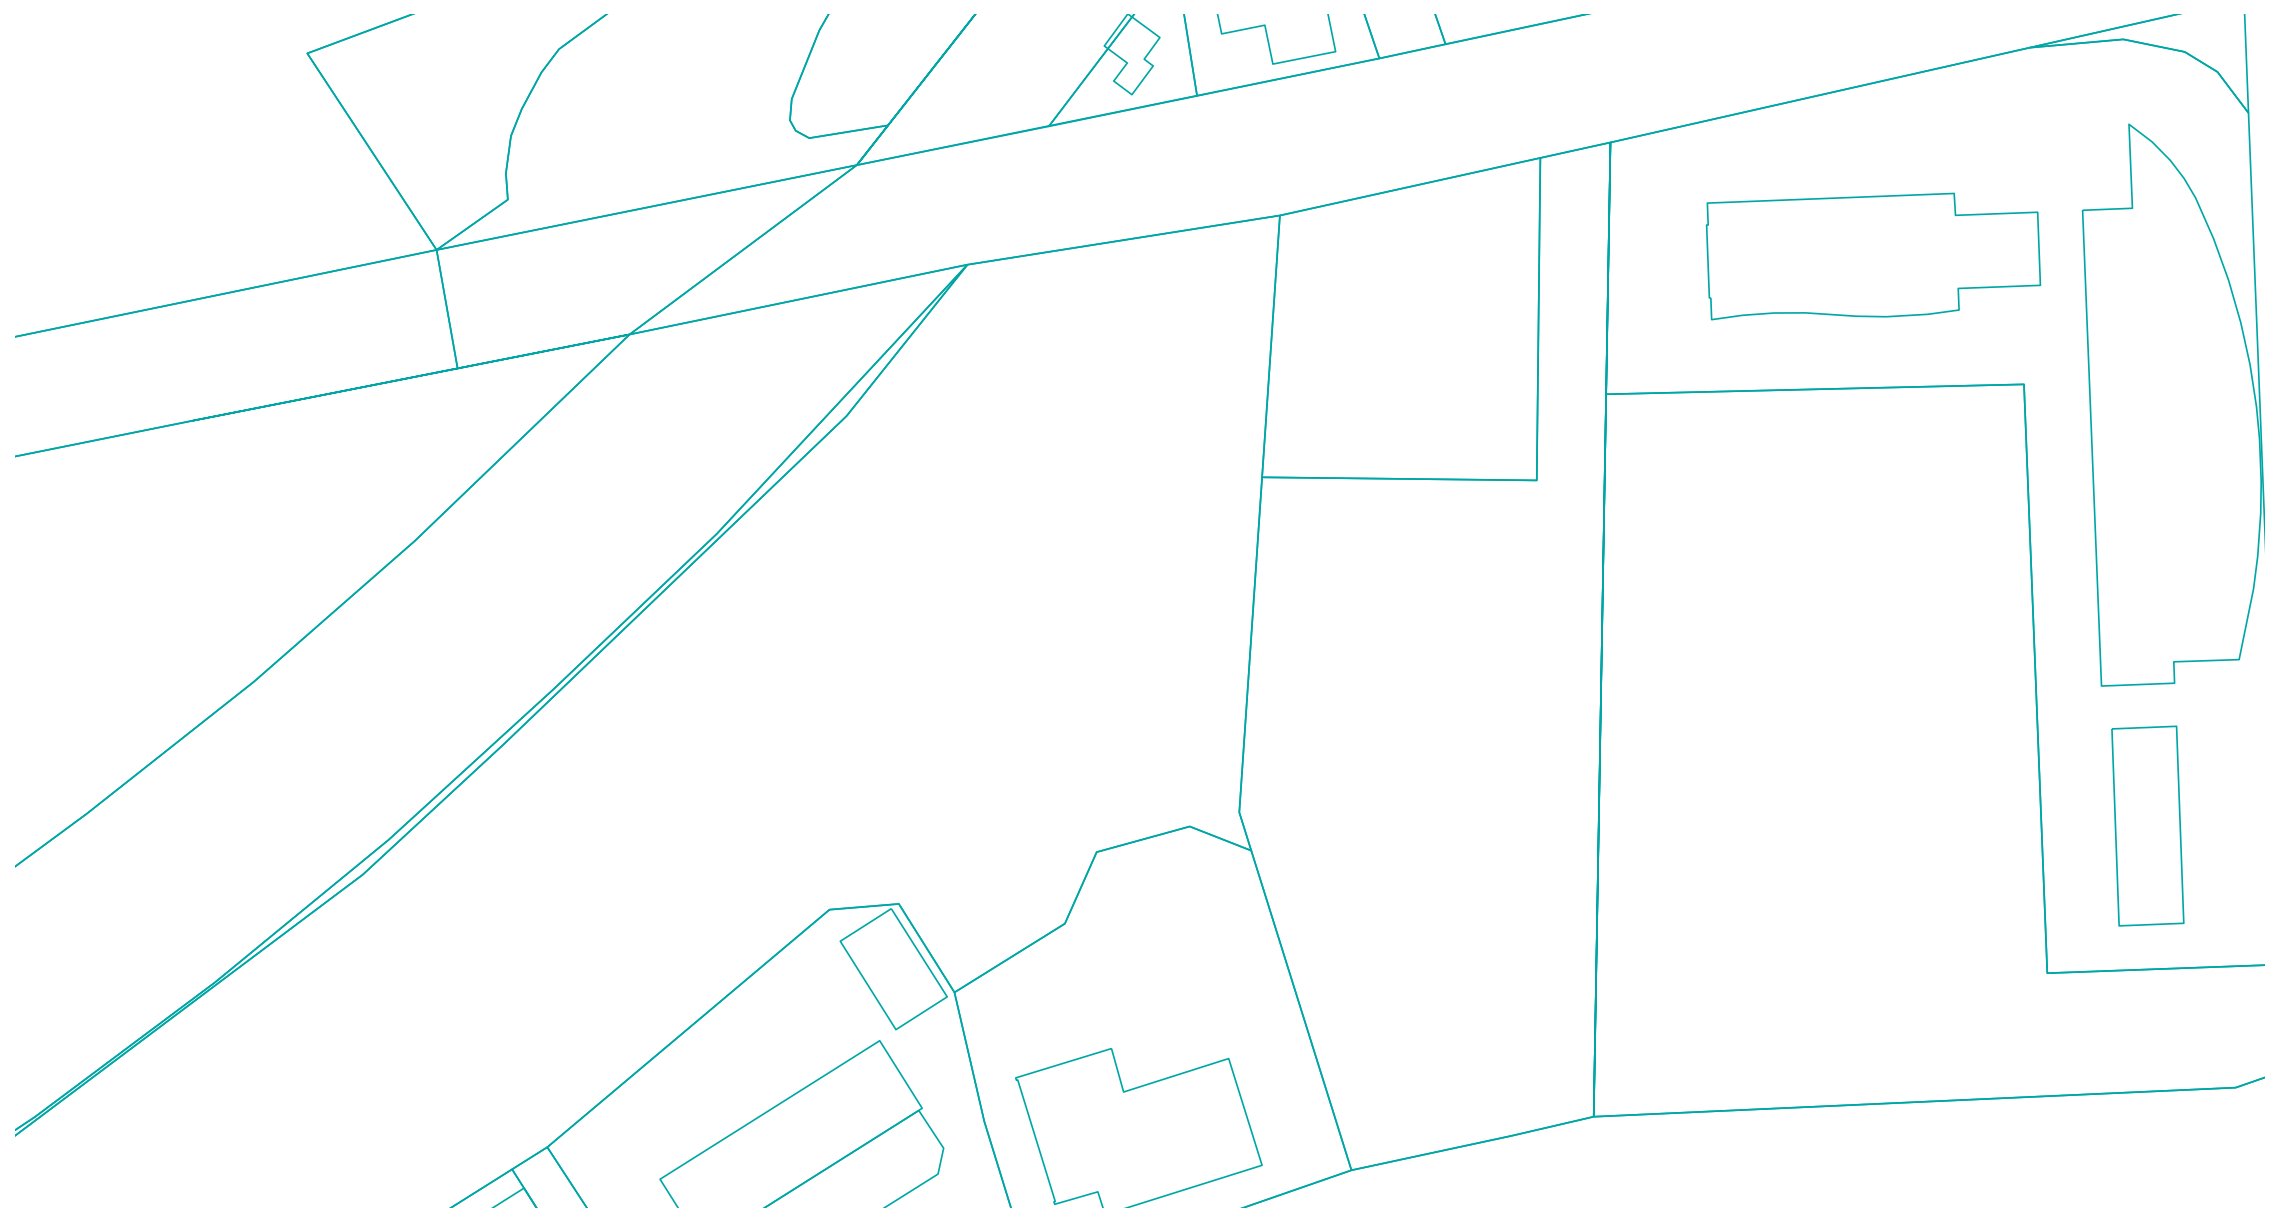

saved raster and alkis


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


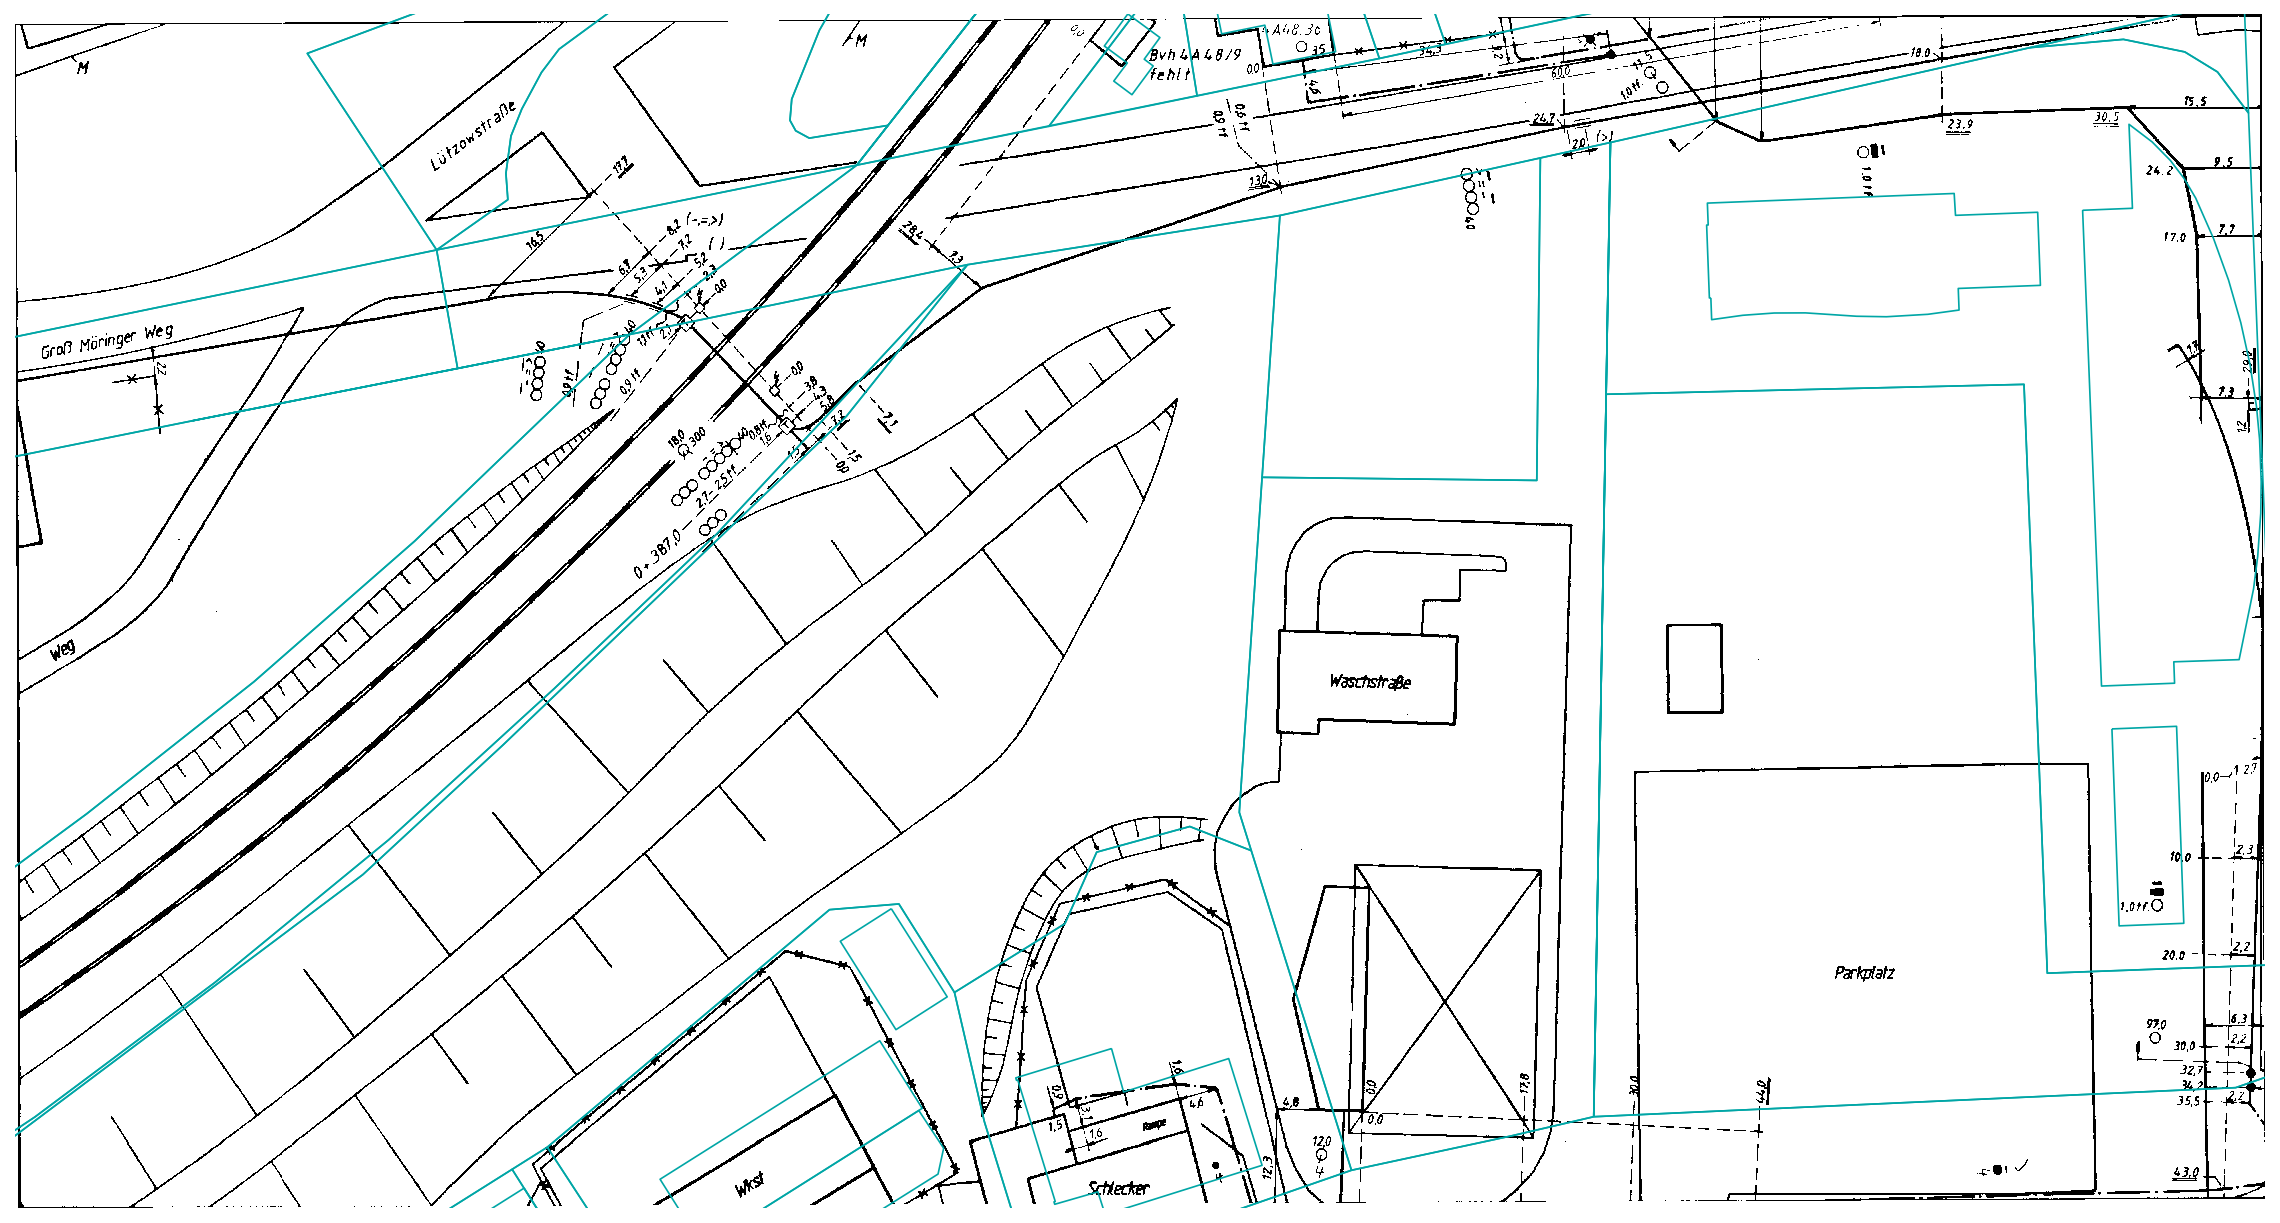

TIF file: 8830hd.tif
Number of intersecting features: 39


In [67]:
# Get LAGEPLAN info once
lageplan_row = stadt_df[stadt_df['layer'] == 'LAGEPLAENE'].iloc[50]
lageplan_polygon = lageplan_row.geometry
lageplan_name = lageplan_row['NAME']
tif_id = lageplan_name.split(prefix)[1]
bounds = lageplan_polygon.bounds

# Filter intersecting features once
intersecting_hu = stadt_df[
    (stadt_df['layer'].isin(['ALKIS_HU', 'ALKIS_FLUR'])) &
    (stadt_df.geometry.intersects(lageplan_polygon))
]

# Common plot settings
def setup_plot(fig, ax):
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    plt.tight_layout(pad=0)

# 1. TIF only
fig1, ax1 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
with rasterio.open(BASE_PATH / "Raster" / f"{tif_id}.tif") as src:
    image = src.read(1)
    ax1.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
setup_plot(fig1, ax1)
plt.savefig(BASE_PATH / "raster.png",
            bbox_inches='tight',
            pad_inches=0,
            dpi=150)
plt.show()

# 2. Vector data only
fig2, ax2 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
intersecting_hu.plot(ax=ax2,
                    facecolor='none',
                    edgecolor='#00A6A6',  # Teal color
                    linewidth=0.8)
setup_plot(fig2, ax2)
plt.savefig(BASE_PATH / "alkis.png",
            bbox_inches='tight',
            pad_inches=0,
            dpi=150)
plt.show()
print("saved raster and alkis")
# 3. Combined overlay
fig3, ax3 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
with rasterio.open(BASE_PATH / "Raster" / f"{tif_id}.tif") as src:
    image = src.read(1)
    ax3.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
intersecting_hu.plot(ax=ax3,
                    facecolor='none',
                    edgecolor='#00A6A6',  # Teal color
                    linewidth=0.8)
setup_plot(fig3, ax3)
plt.show()

print(f"TIF file: {tif_id}.tif")
print(f"Number of intersecting features: {len(intersecting_hu)}")

## match images
left alkis right raster

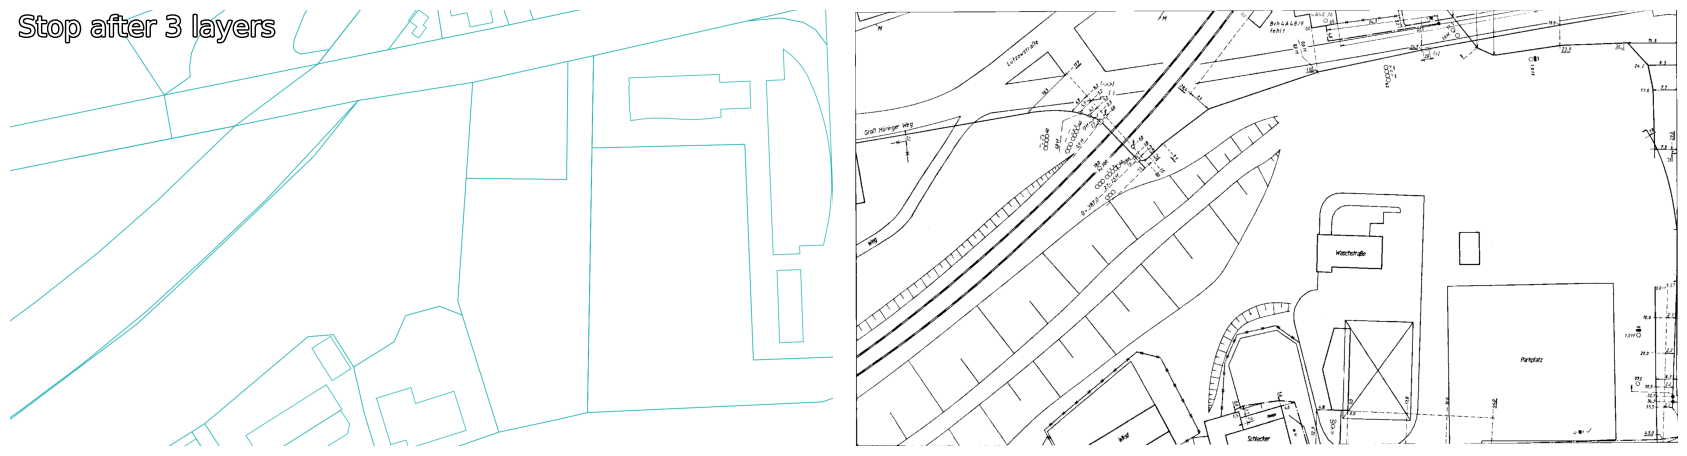

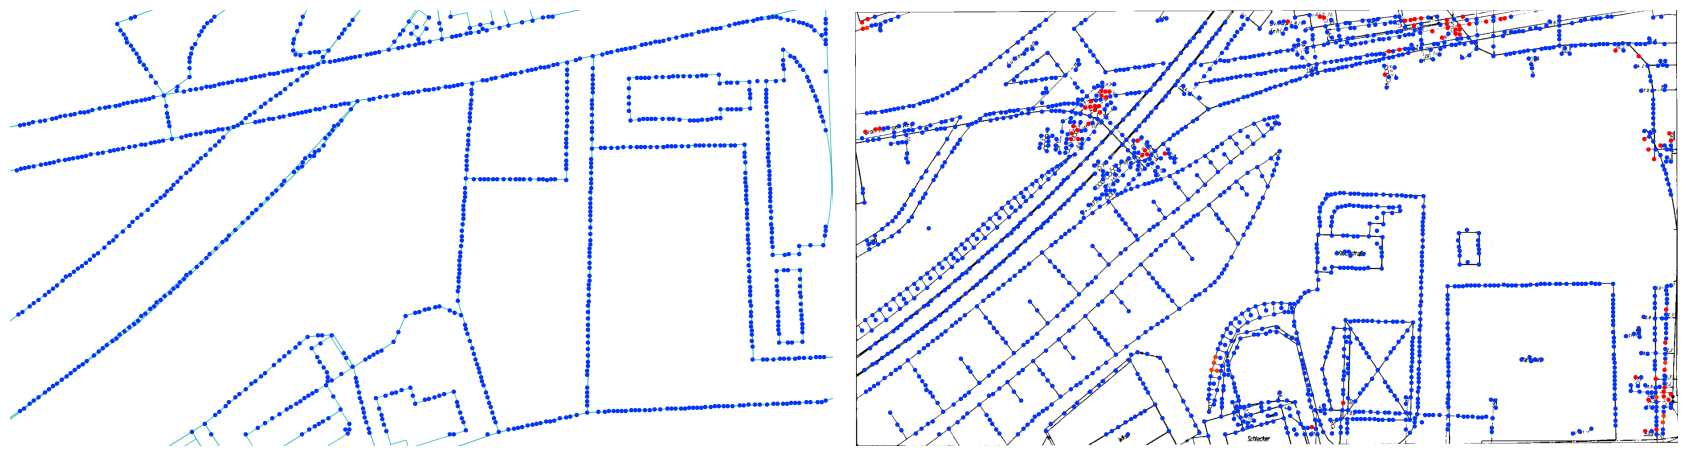

In [69]:
image0 = load_image(BASE_PATH / "alkis.png")
image1 = load_image(BASE_PATH / "raster.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)